In [4]:
import pyccl as ccl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys
import scipy
from functools import lru_cache

MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)

from MGCAMB import camb


In [5]:
# Import the f(R) matter power spectrum boost class.
from emantis import FofrBoost

# Initialise and emulator instance.
emu_fR = FofrBoost()


# For doing Gaussian processes
sys.path.append("/home/c2042999/forge_emulator")

from FORGE_emulator import FORGE

#create an emulator instance; 
#it's recommended to do this once at the start as multiple 
#instances might lead to duplications in training work
forge_emulator = FORGE()

In [57]:
"""For tests"""

cosmo_testing = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)

cosmo_testing_FORGE = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9,
                           Omega_g = 0.0)

In [58]:
"""Linear matter power spectra f(R)"""

@lru_cache(maxsize=128)  # You can adjust maxsize according to your memory constraints
def create_interpolator(cosmo_values, MGparams_tuple):
    
    H0rc, fR0, n, mu, Sigma = MGparams_tuple

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_values['h'] * 100, 
                       ombh2=cosmo_values['Omega_b'] * cosmo_values['h']**2, 
                       omch2=cosmo_values['Omega_c'] * cosmo_values['h']**2, 
                       omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=cosmo_values['n_s'], As=cosmo_values['A_s'])
    pars.set_mgparams(MG_flag=3, GRtrans=0.0, QSA_flag=4, F_R0=fR0, FRn=1.0)
    pars.NonLinear = camb.model.NonLinear_none
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, zmax=100)
    return PK

def P_k_fR_lin(cosmo, MGparams, k, a):
    if MGparams[1] == 0:
        return ccl.linear_matter_power(cosmo, k=k, a=a)
    else:
        MGparams_tuple = tuple(MGparams)
        PK = create_interpolator(cosmo, MGparams_tuple)
        return PK.P(1/a-1, k)


"""Linear matter power f(R) (function for mu(k,a))"""
def mu_fR(fR0, cosmo, k, a):
    # k is in units 1/Mpc
    # We want H0 in units 1/Mpc, so H0 = 100h/c
    if fR0 == 0:
        return np.ones(len(k))
    else:
        # from ReACT paper
        f0 = fR0 / (cosmo["h"]*100/3e5)**2
        Zi = (cosmo["Omega_m"] + 4*a**3*(1-cosmo["Omega_m"]))/a**3
        Pi = (k/a)**2 + Zi**3/2/f0/(3*cosmo["Omega_m"] - 4)**2
        return 1 + (k/a)**2/3/Pi


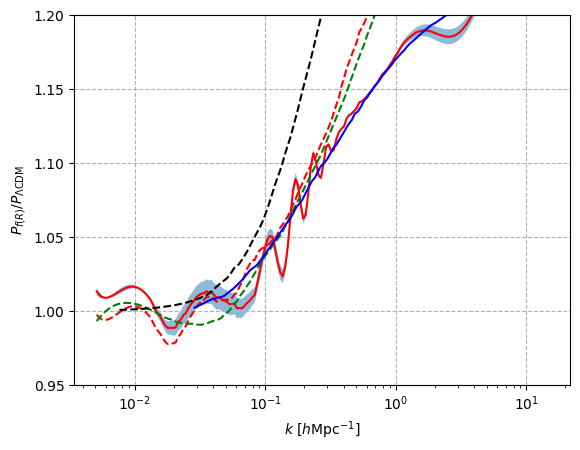

In [61]:
# Define the cosmological parameters and scale factor.
logfR0 = 5
aexp = 1
#now we want to make predictions for the following cosmology
omega_m = cosmo_testing["Omega_m"]
h = cosmo_testing["h"]
sigma8_lcdm = ccl.sigma8(cosmo_testing)

# Predict the power spectrum boost for a given set of cosmological parameters and a given scale factor.
boost_pred = emu_fR.predict_boost(omega_m, sigma8_lcdm, logfR0, aexp, k = None)

# Recover then k-bins centres (h/Mpc) at which the boost prediction is given by default.
kbins = emu_fR.kbins

pk_GR_test_fR_emu, error = forge_emulator.predict_Pk(1/aexp -1, omega_m, h, 7, sigma8_lcdm)
pk_GR_test_fR = ccl.nonlin_matter_power(cosmo_testing, k=forge_emulator.k*cosmo_testing["h"], a=1)*cosmo_testing["h"]**3
pk_GR_test_FORGE = ccl.nonlin_matter_power(cosmo_testing_FORGE, k=forge_emulator.k*cosmo_testing["h"], a=1)*cosmo_testing["h"]**3

Bk, error = forge_emulator.predict_Bk(1/aexp -1, omega_m, h, logfR0, sigma8_lcdm)
Pk, error = forge_emulator.predict_Pk(1/aexp -1, omega_m, h, logfR0, sigma8_lcdm)

plt.plot(forge_emulator.k, Pk/pk_GR_test_FORGE, ls = '-', color="r")
plt.plot(forge_emulator.k, Bk, ls = '--', color="r")
plt.fill_between(forge_emulator.k, (Pk+error)/pk_GR_test_FORGE, (Pk-error)/pk_GR_test_FORGE, alpha=0.5)
plt.plot(forge_emulator.k, Pk/pk_GR_test_fR_emu, ls = '--', color="g")

#### Linear ####
pk_GR_test_lin_fR = ccl.linear_matter_power(cosmo_testing, k=forge_emulator.k, a=1)

pk_test_fR_lin = P_k_fR_lin(cosmo_testing, [0.0,10**(-logfR0),1,0,0], forge_emulator.k, 1)

plt.plot(forge_emulator.k/cosmo_testing["h"], pk_test_fR_lin/pk_GR_test_lin_fR, "k--")

# Plot the predicted boost.
plt.plot(kbins, boost_pred, color="b")
plt.xscale('log')
plt.ylim(0.95,1.2)
plt.xlabel(r'$k \ \left[h\mathrm{Mpc}^{-1}\right]$')
plt.ylabel(r'$P_{f(R)}/P_{\Lambda\mathrm{CDM}}$')
plt.grid(True, linestyle='--')
plt.show()




In [13]:
# NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity, units (Mpc)^3
    """
    H0rc, fR0, n, mu = MGparams

    sigma8_VAL_lcdm = ccl.sigma8(cosmo)
    
    pkratio_fR, error = forge_emulator.predict_Bk(1/a -1, cosmo["Omega_m"], cosmo["h"], -np.log10(fR0), sigma8_VAL_lcdm)

    pkratio_fR = np.interp(k/cosmo["h"], forge_emulator.k, pkratio_fR)
    # k is in units [h/Mpc]

    Pk_ccl = ccl.power.nonlin_power(cosmo, k, a=a) # units (Mpc)^3
    Pk = pkratio_fR*Pk_ccl

    return Pk

In [14]:
@lru_cache(maxsize=128)  # You can adjust maxsize according to your memory constraints
def create_interpolator(cosmo_values, MGparams_tuple):
    
    H0rc, fR0, n, mu = MGparams_tuple

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_values['h'] * 100, 
                       ombh2=cosmo_values['Omega_b'] * cosmo_values['h']**2, 
                       omch2=cosmo_values['Omega_c'] * cosmo_values['h']**2, 
                       omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=cosmo_values['n_s'], As=cosmo_values['A_s'])
    pars.set_mgparams(MG_flag=3, GRtrans=0.0, QSA_flag=4, F_R0=fR0, FRn=1.0)
    pars.NonLinear = camb.model.NonLinear_none
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, zmax=100)
    return PK

def P_k_fR_lin(cosmo, MGparams, k, a):
    if MGparams[1] == 0:
        return ccl.linear_matter_power(cosmo, k=k, a=a)
    else:
        MGparams_tuple = tuple(MGparams)
        PK = create_interpolator(cosmo, MGparams_tuple)
        return PK.P(1/a-1, k)

In [15]:
cosmo_testing = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)

k_test = np.logspace(-1.5, 0, 100)

pk_test = P_k_NL_fR(cosmo_testing, [0.0,9e-5,1,0], k_test, 1)
pk_test_lin = P_k_fR_lin(cosmo_testing, [0.0,9e-5,1,0], k_test, 1)

pk_GR_test = ccl.nonlin_matter_power(cosmo_testing, k=k_test, a=1)
pk_GR_test_lin = ccl.linear_matter_power(cosmo_testing, k=k_test, a=1)


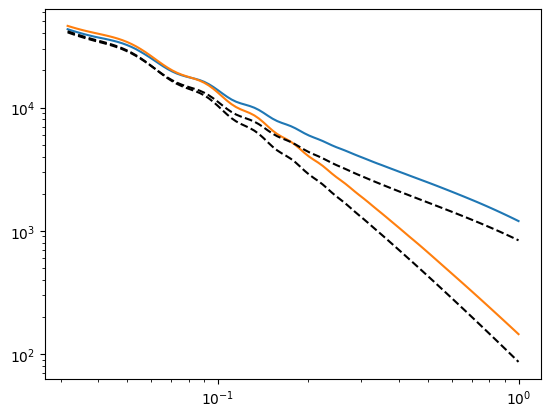

In [16]:
plt.loglog(k_test,pk_test)
plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_GR_test, "k--")
plt.loglog(k_test,pk_GR_test_lin, "k--")
